<div style="background-image:url(images/header.svg); padding: 0px; background-size:cover; background-opacity:50%; border-radius:5px; height: 250px">
    <div style="float:right; margin: 50px; padding: 20px; background:rgba(255,255,255,0.7); width: 50%; height: 150px">
        <div style="position:relative; top:50%; transform: translateY(-50%)">
            <div style="font-size: xx-large; font-weight:900; color:rgba(0,0,0,0.8); line-height:100%">Applied Seismology</div>
            <div style="font-size: large; padding-top: 20px; color:rgba(0,0,0,0.5)">Lab: Instrument Response</div>
        </div>
    </div>
</div>

Seismo-Live: http://seismo-live.org

##### Authors:
* Carl Tape ([@carltape](https://github.com/carltape))
* Lion Krischer ([@krischer](https://github.com/krischer))
---

based on *GEOS 626: Applied Seismology from Carl Tape*

---

In [1]:
# This cell does two things: 
# (1) make plots appear in the notebook and (2) creates prettier plots.
# Make sure to execute it at least once!
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = 10, 5

### L1 Instructions

This is a Python and ObsPy version of the above mentioned lab. We will perform the same calculations and create similar plots but we will be using different services, data formats, and tools.

It aims to teach students how to calculate, visualize and use instruments responses.

### L2 Computing and plotting instrument response, $I(ω)$ 

##### Acquiring Data

The first step when working with instrument data is to acquire it. Nowadays this is mostly done using the *station* web service defined by the [FDSN](http://www.fdsn.org/) (International Federation of Digital Seismograph Networks). Once you know how to use this you can use it to download data from data centers across the globe including IRIS, ORFEUS, ETH, RESIF, GEONET, and many more. Notable exceptions are most Asian countries and countries that don't freely share their data.

With ObsPy this works by first importing the FDSN `Client` class and then initializing it with the data center you want to download from. For this lab we will use data from the Geoscope project, which can be downloaded from IRIS (its "home" data center is the IPGP in Paris which you can also use - just replace `"IRIS"` with `"IPGP"` in the following code box - but most of you will be more familiar with IRIS).

See the [documentation of obspy.clients.fdsn](http://docs.obspy.org/packages/obspy.clients.fdsn.html) for more details.

In [2]:
from obspy.clients.fdsn import Client
# ObsPy knows which website to connect to for many data center.
# For others you can also pass the full URL.
c = Client("IRIS")

Station information is time dependent due to for example changed sensors, new calibrations, or other changes. It is thus important to specify the time frame for which to request response information.

ObsPy handles absolute times with the `UTCDateTime` class. See the [documentation](http://docs.obspy.org/packages/autogen/obspy.core.utcdatetime.UTCDateTime.html) and the [tutorial](http://docs.obspy.org/tutorial/code_snippets/utc_date_time.html) for more information.

In [3]:
import obspy
# Create two times which we will later use to download time series data.
starttime = obspy.UTCDateTime(2004, 12, 26, 0, 58, 50)
# Create a new time object by adding 5 days to the previous ones. Time
# differences are in seconds.
endtime = starttime + 86400 * 5

We will use the `CAN` station which is located in Canberra, Australia, and featured in [*Park et al.* (2005, Figure 1)](http://dx.doi.org/10.1126/science.1112305). Please note that in many cases the station code is not unique and in practice the network code is also required. See the ObsPy tutorials for more details about these concepts. The `get_station()` method of the FDSN `Client` object returns station/instrument information. Once again see its [documentation](http://docs.obspy.org/packages/autogen/obspy.clients.fdsn.client.Client.get_stations.html) for more information.

In [4]:
# This will get all stations that satisfy all constraints simultaneosly.
inv = c.get_stations(network="G", station="CAN", channel="LHZ", 
                     level="response", 
                     starttime=starttime, endtime=endtime)
print(inv)

Inventory created at 2016-04-12T07:39:38.000000Z
	Created by: IRIS WEB SERVICE: fdsnws-station | version: 1.1.20
		    http://service.iris.edu/fdsnws/station/1/query?starttime=2004-12-26...
	Sending institution: IRIS-DMC (IRIS-DMC)
	Contains:
		Networks (1):
			G
		Stations (1):
			G.CAN (Canberra, Australia)
		Channels (1):
			G.CAN..LHZ


The `station` services return `StationXML` files which are the most modern and future proof data format for station and instrument information. **If possible at all: Always try to use StationXML files!**

##### Plotting the Instrument Response

We can now plot the instrument response with the `plot_response()` method. The `min_freq` argument determines the lowest plotted frequency - the maximum plotted frequency is always the Nyquist frequency.

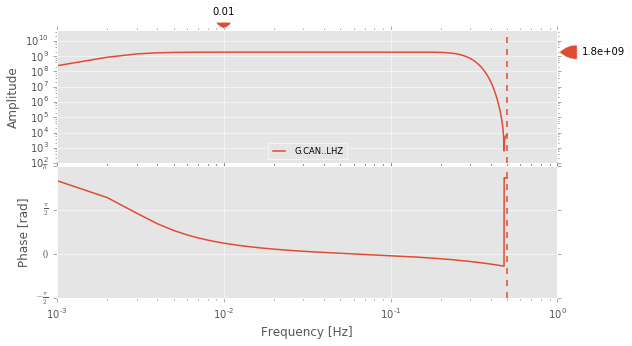

In [5]:
inv.plot_response(min_freq=0.001);

These are [Bode plots](https://en.wikipedia.org/wiki/Bode_plot) and show the amplitude $A(\omega)$ and the phase $\phi(\omega)$ response where

$$
I(\omega) = A(\omega) e^{i \phi(\omega)}
$$

Note that the formulas use $\omega$ but the plots show the frequency $f$ with $\omega = 2 \pi f$. The first variant usually simplifies notation whereas the latter one facilitates physical interpretation.

This plot does not just show the instrument response - it shows the response of the whole recording chain from observed ground motion to actually stored data. This includes the analoge response of the actual seismometer, the analog-to-digitial converter (DAC), and possible digital filter stages.

The sampling rate of this channel is 1 sample per second ($\Delta T$ = 1s), so the **Nyquist frequency**, which is defined as

$$
f_{Nyq} = 1 / (2 \Delta t),
$$

is $f_{Nyq}$ = 0.5 Hz. The above plot does not show frequencies higher than the Nyquist frequency (the vertical dashed line) as these frequencies do not exist in the data and thus have no physical meaning.

Have a look at the details of the response information of this channel:

In [6]:
inv[0][0][0].response

Channel Response
	From M/S (VELOCITY in Meters Per Second) to COUNTS (DIGITAL UNIT in Counts)
	Overall Sensitivity: 1.84484e+09 defined at 0.010 Hz
	5 stages:
		Stage 1: PolesZerosResponseStage from M/S to V, gain: 2252
		Stage 2: PolesZerosResponseStage from V to V, gain: 1
		Stage 3: CoefficientsTypeResponseStage from V to COUNTS, gain: 819200
		Stage 4: CoefficientsTypeResponseStage from COUNTS to COUNTS, gain: 1
		Stage 5: CoefficientsTypeResponseStage from COUNTS to COUNTS, gain: 1

Here we see that it consists of multiple stages that convert from one unit to another. The final instrument response is the multipication (in the frequency domain) of all of these.

**QUESTION:** What are the input and output units of the whole instrument? What does that mean physically?

**QUESTION:** How does one conceptually remove the instrument response from recorded data?

##### Incomplete Responses

You can also only plot the response of a range of stages. The plotted sensitivity in Obspy 1.0.1 is the overall sensitivity of all stages and not only the chosen ones - thus the plot looks a bit strange. This will be rectified [soon](https://github.com/obspy/obspy/issues/1368).

/Users/lion/.miniconda3/envs/seismo_live/lib/python3.5/site-packages/matplotlib/axes/_axes.py:519: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


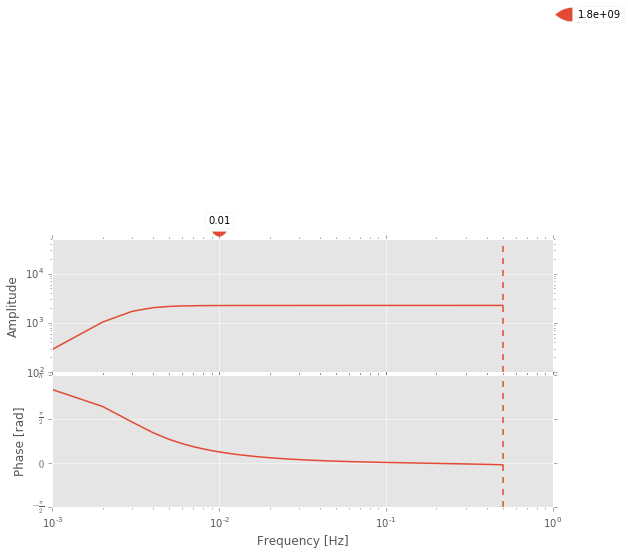

In [7]:
inv[0][0][0].plot(0.001, start_stage=1, end_stage=1);

Note that the major differences (except a constant factor) are close to the Nyquist frequency - these are due to the here not plotted decimation and FIR filter stages. In many cases it is sufficient to only use Poles & Zeros information but there are stations where this is not true. As it is tedious to manually check everytime: **There is no reason to not use the full chain instrument response if it is available!**

##### Output Units

Modern seismometers usually record the velocity of ground motion, strong motions sensor record acceleration.

**QUESTION:** Why is that?

The instrument response describes how incoming data (in whatever the instrument measures) it transformed into what is finally stored in a file. Restoring original ground motion requires the inversion of that process. The deconvolution of the instrument response as written for example in a StationXML file will convert data back to its original units.

If your analysis requires other units it is best to perform the integration or differentiation during the instrument deconvolution. That deconvolution is usually performed in the frequency domain - once there integration/differentiation is almost free and the most accurate it gets.

The following plots show the instrument response $I_d(\omega)$ from displacement, velocity $I_v(\omega)$, and acceleration $I_a(\omega)$.

Displacement


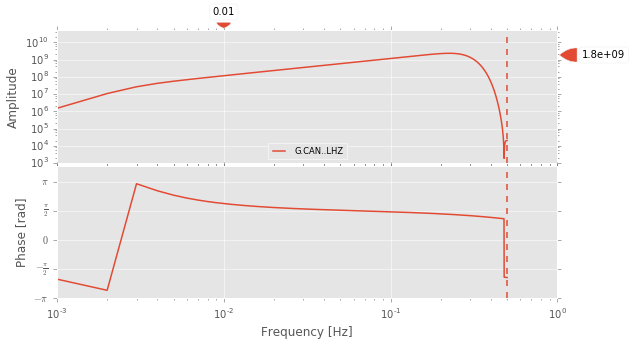

Velocity


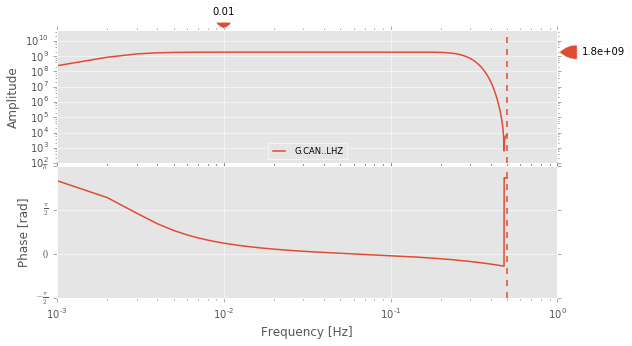

Acceleration


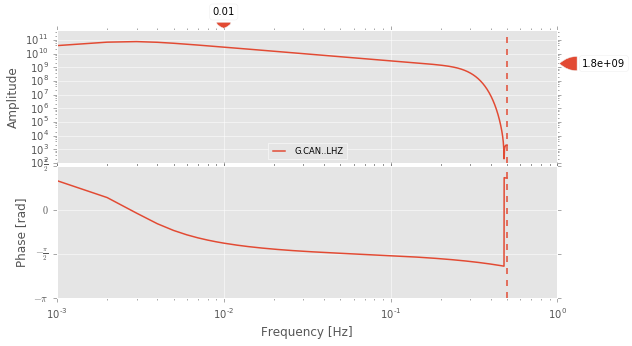

In [8]:
print("Displacement")
inv.plot_response(0.001, output="DISP")
print("Velocity")
inv.plot_response(0.001, output="VEL")
print("Acceleration")
inv.plot_response(0.001, output="ACC");


Basic properties of the Fourier transform result in 

$$
\begin{align}
X_v(\omega) &= (i \omega) X_d(\omega) \\
X_a(\omega) &= (i \omega) X_v(\omega)
\end{align}
$$

where $X_d$, $X_v$, and $X_a$ are the Fourier transforms of displacement $x_d(t)$, velocity $x_v(t)$, and acceleration $x_a(t)$.

We also have the relationship between ground motion, instrument response, and the output form the seismometer:

$$
\begin{align}
x_a(t) * i_a(t) &= c(t) \\
X_a(\omega) I_a (\omega) &= C(\omega) 
\end{align}
$$

Here we have assumed that the instrument response is described with respect to acceleration. But we could alternatively consider the instrument response with respect to velocity or displacement; **the key point is that what comes out of the seismometer,** $C(\omega)$**, is fixed.** But we can descibe the input ground motion as displacement, velocity, or acceleration. Showing all three together and omitting explicit $\omega$ dependence, we have

$$
\begin{align}
C &= X_a I_a = X_v I_v = X_d I_d\\
  &= (i\omega) X_v I_a = (i \omega) X_d I_V = X_d I_d \\
  &= (i\omega)^2 X_d I_a = (i \omega) X_d I_V = X_d I_d \\
I_v &= I_d \ (i\omega)\\
I_a&= I_v \ (i\omega)\\
\end{align}
$$

It turns out that the effect of differentiation in the time domain leads to an *increase by a factor of one* in the slope of the amplitude spectrum, $|H(\omega)|$, in log-log space, for example, by changing from $X_d(\omega)$ to $X_v(\omega)$. But when we are looking at the *instrument response*, the slope will *decrease by a factor of one* when changing from, say, $I_d(\omega)$ to $I_v(\omega)$.

We see this in the above figure. Consider the flat segment in the velocity correction spectrum: the displacement shows a corresponding slope increase whereas the acceleration show a slope decrease.

**QUESTION:** What is meant by a "broadband" seismometer?

### L3 Deconvolve instrument response for a seismogram

We will download some data and remove its instrument response.

The first step is to get some data - we will once again use the FDSN web services but this time also to download waveform data.

In [9]:
otime = obspy.UTCDateTime(2004, 12, 26, 0, 58, 50)
duration = 5 * 86400
starttime = otime
endtime = starttime + duration

st = c.get_waveforms(network="G", station="CAN", location="", channel="LH*",
                     starttime=starttime, endtime=endtime)

# Do it once again to also get the response information of the vertical channels.
inv = c.get_stations(network="G", station="CAN", location="", channel="LH*",
                     starttime=starttime, endtime=endtime, level="response")

We will now show what the main arrival looks like at bandpass 50-500s with and without the instrument deconvolution.

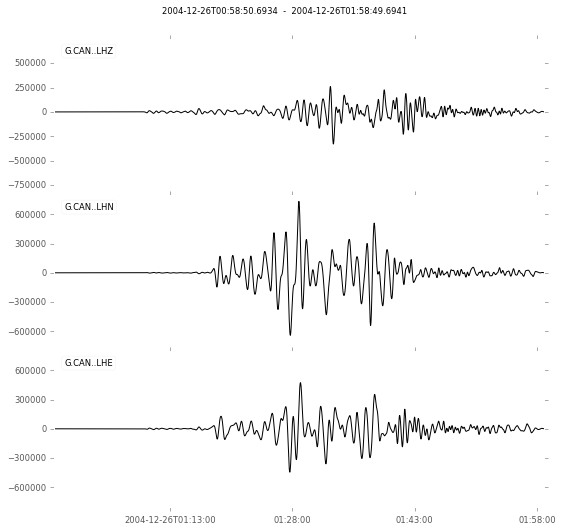

In [10]:
# Plot the first hour - slice() will leave the original 
# data stream intact and just returns a new view on the
# data.
st.slice(endtime=otime + 3600).copy().taper(0.05).filter(
    "bandpass", freqmin=1.0 / 500.0, freqmax=1.0 / 50.0).plot()

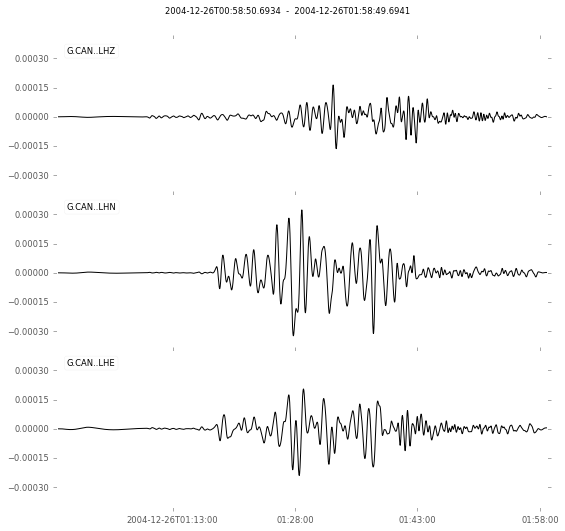

In [11]:
# Now plot the same but with the instrument removed.
# Note the copy() here as remove_response() would otherwise
# remove the contents of the original data stream.
st.slice(endtime=otime + 3600).copy().remove_response(
    inventory=inv, output="VEL").taper(0.05).filter(
    "bandpass", freqmin=1.0 / 500.0, freqmax=1.0 / 50.0).plot()

What are the differences? What is their cause?

We will now plot the amplitude spectrum over 0.2 - 1.0 mHz to show the gravest normal mode peaks. We will only use the vertical component to simplify things.

We will first do it without instrument correction

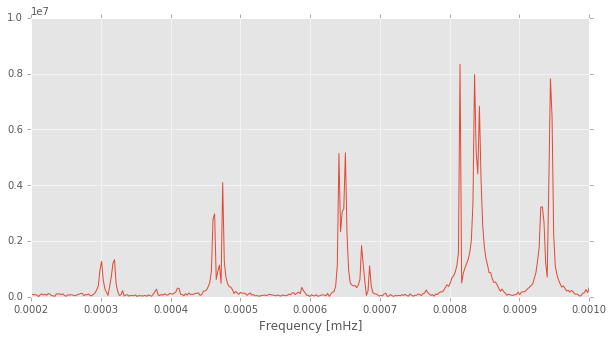

In [12]:
import numpy as np

tr = st.select(component="Z")[0].copy().taper(0.05)

# rfft() is a varient of the FFT for real valued input.
# The negative frequencies of a DFT for purely real valued
# input are just the complex conjugates of the corresponding
# positive frequencies and thus redundant.
D = np.fft.rfft(tr.data)
# Return the corresponding frequencies.
freqs = np.fft.rfftfreq(tr.stats.npts, d=tr.stats.delta)

plt.plot(freqs, np.abs(D))
plt.xlim(0.2E-3, 1.0E-3)
plt.ylim(0, 1E7)
plt.xlabel("Frequency [mHz]")
plt.show()

Instrument removal is, in practice, a tricky and unstable operation. Have a look at the [documentation of the remove_response() method](http://docs.obspy.org/packages/autogen/obspy.core.trace.Trace.remove_response.html) and try to understand the meaning of the various parameters and when you would want to use each.

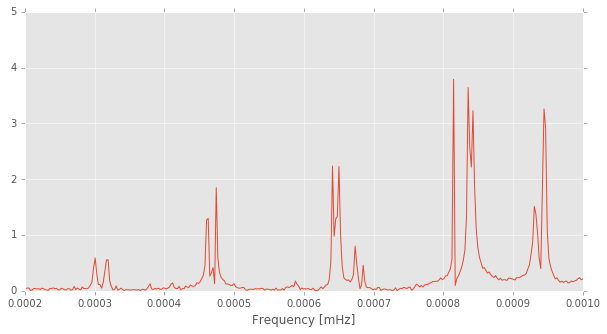

In [13]:
# Remember the copy()!
tr = st.select(component="Z").copy().remove_response(inventory=inv, 
                                                     output="DISP")[0]

D = np.fft.rfft(tr.data)
freqs = np.fft.rfftfreq(tr.stats.npts, d=tr.stats.delta)

plt.plot(freqs, np.abs(D))
plt.xlim(0.2E-3, 1.0E-3)
plt.ylim(0, 5.0)
plt.xlabel("Frequency [mHz]")
plt.show()

Are there any difference to the previous versions? If yes - what are they? Keep in mind that the previous plot is based on velocity data, whereas this one has been corrected to displacement.

We are interested in the spectrum of the data so we don't really need to use instrument corrected data to calculate the spectrum - we can just calculate the spectrum and divide by the response.

/Users/lion/.miniconda3/envs/seismo_live/lib/python3.5/site-packages/ipykernel/__main__.py:9: RuntimeWarning: divide by zero encountered in true_divide


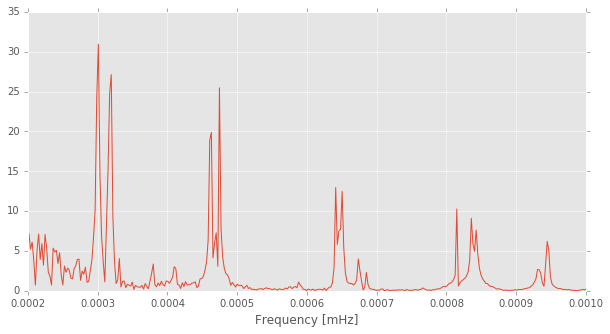

In [14]:
tr = st.select(component="Z")[0].copy().taper(0.05)

D = np.fft.rfft(tr.data)
freqs = np.fft.rfftfreq(tr.stats.npts, d=tr.stats.delta)
# Advanced ObsPy-foo to directly get the complex response.
freq_response, _ = \
    inv.select(channel="LHZ")[0][0][0].response.get_evalresp_response(
        tr.stats.delta, tr.stats.npts, output="DISP")

plt.plot(freqs, np.abs(D)/ np.abs(freq_response))
plt.xlim(0.2E-3, 1.0E-3)
plt.ylim(0, 35.0)
plt.xlabel("Frequency [mHz]")
plt.show()

Note that this is quite different then the previous spectrum. **Why?** Keep in mind that we are operating far from the passband of the instrument. The following two plots as well as the
[documentation of the remove_response() method](http://docs.obspy.org/packages/autogen/obspy.core.trace.Trace.remove_response.html) should help you answer that question. Which alternative yields the more correct answer?

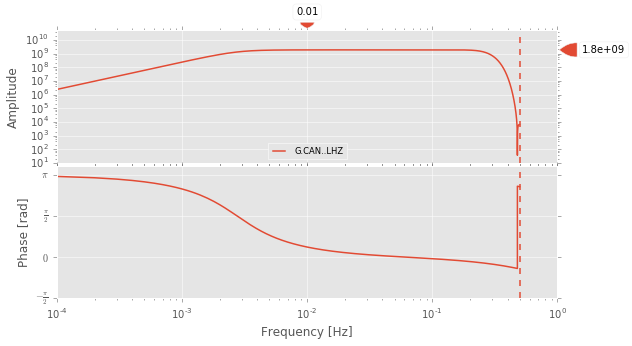

In [15]:
inv.select(channel="LHZ").plot_response(min_freq=0.0001);

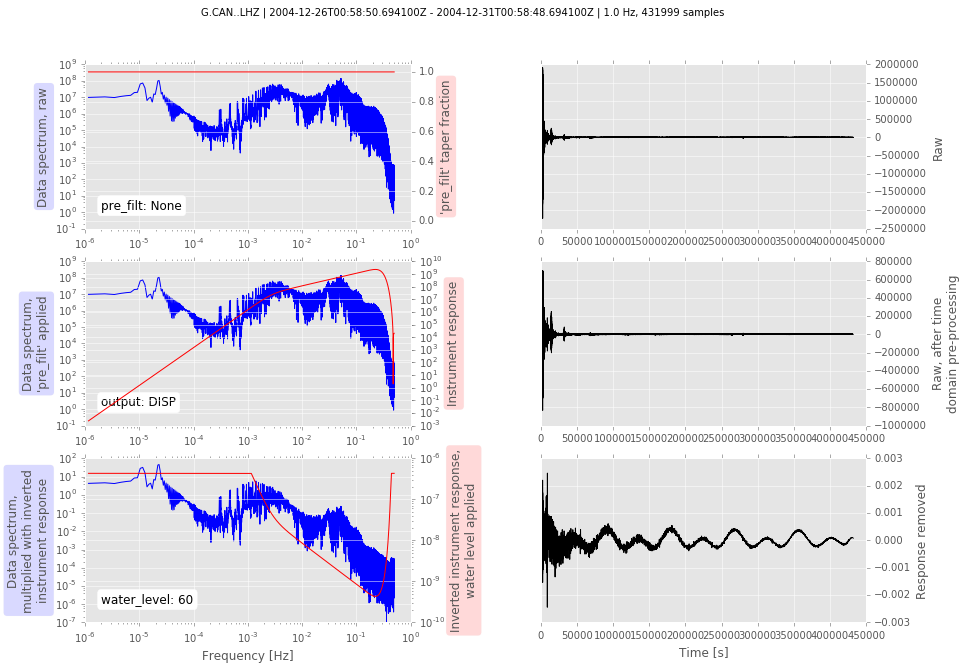

In [16]:
tr = st.select(component="Z").copy().remove_response(
    inventory=inv, output="DISP", plot=True)[0]